In [1]:
import pandas as pd
import os

df = pd.read_excel('iCoreData_Oct-Jan.xls')
df.head()

,Name,DateTime,AVG_CPU_UTIL,AVG_MEM_UTIL
0,APP_HOST121,2018-10-02,12.177083,28.586111
1,APP_HOST133,2018-10-02,2.426389,37.436111
2,APP_HOST134,2018-10-02,4.949306,39.765278
3,APP_HOST136,2018-10-02,5.928472,21.297917
4,APP_HOST138,2018-10-02,8.874306,33.400000


In [2]:
df.columns = ['Name','DateTime','AVG_CPU_UTIL','AVG_MEM_UTIL']

In [3]:
grouped = df.groupby('Name')

for x in grouped:
    
    name = x[0].strip()
    dframe = x[1]
    print(dframe.head())
    
#     dframe.drop(['AVG_MEM_UTIL'], axis =1, inplace = True)
#     print(dframe.head())

    dir_name = 'cpu_forecast'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    filename = name+'.csv'
    
    path = os.path.join(dir_name, filename)
    print(path)
    
    dframe.to_csv(path, index=False)

                      Name      DateTime  AVG_CPU_UTIL  AVG_MEM_UTIL
1152   APP_HOST12            2018-11-22       0.023511      7.000000
1181   APP_HOST12            2018-11-23       1.586806     16.052083
1210   APP_HOST12            2018-11-24       0.571627     15.651599
1239   APP_HOST12            2018-11-25       0.593880     16.645341
1267   APP_HOST12            2018-11-26       2.054861     20.731944
cpu_forecast\APP_HOST12.csv
                    Name      DateTime  AVG_CPU_UTIL  AVG_MEM_UTIL
0    APP_HOST121           2018-10-02      12.177083     28.586111
22   APP_HOST121           2018-10-03      28.436806     35.864583
44   APP_HOST121           2018-10-04      20.803472     35.450694
66   APP_HOST121           2018-10-05      20.756420     34.387830
88   APP_HOST121           2018-10-06      20.957865     34.891854
cpu_forecast\APP_HOST121.csv
                    Name      DateTime  AVG_CPU_UTIL  AVG_MEM_UTIL
1    APP_HOST133           2018-10-02       2.426389     37.

In [4]:
files = []
for f in os.listdir(dir_name):
    if os.path.isfile(os.path.join(dir_name,f)):
        files.append(f)

print(files)
print(len(files))

['APP_HOST12.csv', 'APP_HOST121.csv', 'APP_HOST133.csv', 'APP_HOST134.csv', 'APP_HOST136.csv', 'APP_HOST138.csv', 'APP_HOST143.csv', 'APP_HOST16.csv', 'APP_HOST70.csv', 'APP_HOST71.csv', 'APP_HOST72.csv', 'ICOREDR_APPHOST230.csv', 'ICORE_TRANSMIT115.csv', 'ICORE_TRANSMIT46.csv', 'OHS_HOST11.csv', 'OHS_HOST126.csv', 'OHS_HOST135.csv', 'OHS_HOST15.csv', 'OHS_HOST150.csv', 'OHS_HOST153.csv', 'OHS_HOST87.csv', 'OHS_HOST99.csv', 'WEBLOGIC_HOST125.csv', 'WEBLOGIC_HOST13.csv', 'WEBLOGIC_HOST145.csv', 'WEBLOGIC_HOST149.csv', 'WEBLOGIC_HOST152.csv', 'WEBLOGIC_HOST154.csv', 'WEBLOGIC_HOST155.csv', 'WEBLOGIC_HOST17.csv']
30


In [14]:
# Import the libraries
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from math import sqrt
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

count = 0
for file in files:
    path = os.path.join(dir_name,file)
    dfr = pd.read_csv(path)
    if (dfr.shape[0] < 35):
        print('REJECTING {} BECAUSE OF LESS THAN 35 RECORDS'.format(file))
    print('CURRENT RUNNING HOST NAME={}'.format(file))
    #print(dfr.head())
    #print(dfr.count())
    print('\n')
    
    dfr1=dfr.iloc[:,1:3]
    cpu_data = dfr1
    #print(cpu_data.head())
    #print(cpu_data.count())
    print('\n')
    
    cpu_data['DateTime'] = pd.to_datetime(cpu_data['DateTime'])
    cpu_data['DateTime'] = pd.to_datetime(cpu_data['DateTime'])
    cpu_data = pd.DataFrame(cpu_data).set_index("DateTime", drop=True)
    #print(cpu_data.head())
    
    #divide into train and validation set
    train = cpu_data[:int(0.7*(len(cpu_data)))]
    test = cpu_data[int(0.7*(len(cpu_data))):]
    print('Traing size:',len(train))
    print('Test size:',len(test))
    #train.plot()
    #test.plot()
    
    stepwise_model = auto_arima(train, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
        
    #stepwise_model.fit(train)
    #results_stepwise_model = stepwise_model.fit(train)
    #results_stepwise_model = stepwise_model.
    #plt.plot(results_stepwise_model.fittedvalues)
    #plt.show()
    print(stepwise_model.aic())
    print(stepwise_model.summary())
    # plot residual errors
    #residuals.plot(kind='kde')
    #print(residuals.describe())
        
    #stepwise_model.fit(train)
    future_forecast = stepwise_model.predict(n_periods=len(test))
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
    #print('future_forecast')
    #print(future_forecast)

    #rms = sqrt(mean_squared_error(test,future_forecast))
    #print(rms)
    # Mean square error 
    error = mean_squared_error(test, future_forecast)
    print('\n')
    print('Printing Mean Squared Error of Predictions...')
    print('Test MSE: %.6f' % error)
    
    plt.plot(list(range(1,len(test)+1)), future_forecast['Prediction'].values,'b-', label='forecast')
    plt.plot(list(range(1,len(test)+1)), test['AVG_CPU_UTIL'].values, 'g-', label='actual')
    plt.legend()
    plt.show(block=True)
    print('================================================End',count,'============================================')
    count+=1

CURRENT RUNNING HOST NAME=APP_HOST12.csv




Traing size: 44
Test size: 19
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds


AttributeError: module 'pyramid' has no attribute '__version__'

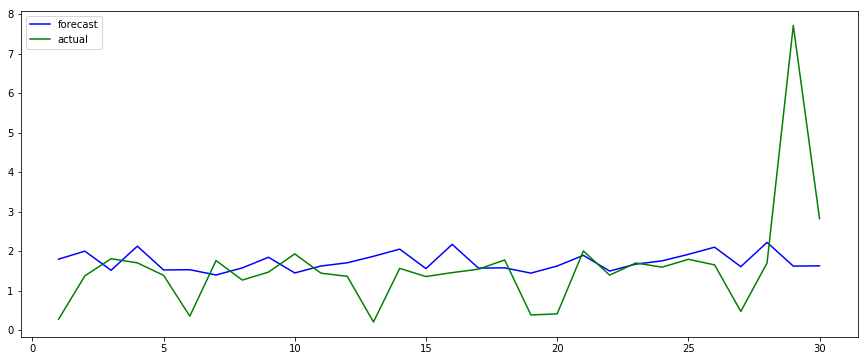

In [28]:
plt.plot(list(range(1,len(test)+1)), future_forecast['Prediction'].values,'b-', label='forecast')
plt.plot(list(range(1,len(test)+1)), test['AVG_CPU_UTIL'].values, 'g-', label='actual')
plt.legend()